<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#特征工程" data-toc-modified-id="特征工程-1">特征工程</a></span><ul class="toc-item"><li><span><a href="#1-数据预处理" data-toc-modified-id="1-数据预处理-1.1">1 数据预处理</a></span><ul class="toc-item"><li><span><a href="#1.1-量纲的问题" data-toc-modified-id="1.1-量纲的问题-1.1.1">1.1 量纲的问题</a></span></li><li><span><a href="#1.2-特征值类型的问题" data-toc-modified-id="1.2-特征值类型的问题-1.1.2">1.2 特征值类型的问题</a></span></li></ul></li><li><span><a href="#2-特征选择" data-toc-modified-id="2-特征选择-1.2">2 特征选择</a></span><ul class="toc-item"><li><span><a href="#2.1-发散性" data-toc-modified-id="2.1-发散性-1.2.1">2.1 发散性</a></span></li><li><span><a href="#2.2-关联性" data-toc-modified-id="2.2-关联性-1.2.2">2.2 关联性</a></span></li></ul></li><li><span><a href="#3-维度下降" data-toc-modified-id="3-维度下降-1.3">3 维度下降</a></span><ul class="toc-item"><li><span><a href="#3.1-逻辑降维" data-toc-modified-id="3.1-逻辑降维-1.3.1">3.1 逻辑降维</a></span></li><li><span><a href="#3.2-算法试验" data-toc-modified-id="3.2-算法试验-1.3.2">3.2 算法试验</a></span></li></ul></li></ul></li></ul></div>

In [37]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [38]:
user_file_path = '/Users/apple/Downloads/nfl/nfl_data.csv'
user_data = pd.read_csv(user_file_path)


In [39]:
# extract UK market

uk_data = user_data.loc[user_data['market'] == 'UK']
uk_data['revenue_usd'].describe()

count    21424.000000
mean        54.929285
std         73.334901
min          0.000000
25%          0.000000
50%         13.000000
75%         98.000000
max        288.000000
Name: revenue_usd, dtype: float64

Text(0, 0.5, 'Frequency')

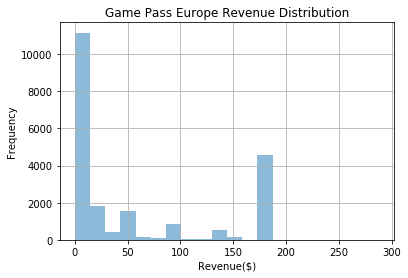

In [40]:
# 看消费的分布情况

uk_data.revenue_usd.hist(bins=20, alpha=0.5)
plt.title("Game Pass Europe Revenue Distribution")
plt.xlabel("Revenue($)")
plt.ylabel("Frequency")

In [41]:
# user_data.customer_id = user_data.customer_id.astype(str)
uk_data = uk_data.drop(['Unnamed: 0', 'date', 'customer_id', 'audience', 'market', 'nflweek', 'platform'], axis=1)
uk_data.head()


,transaction_id,segment,gender,age_group,tickets,shop,fantasy,new_to_database,email_opt_in,favourite_team,sku,buy_type,converted_free_trial,revenue_usd
0,a-s00338989,Acq,U,26-30,0,0,1,0,1,1,Pro,1,0,179
1,a-s00339056,Acq,M,31-35,0,0,1,0,0,1,Pro,0,0,0
2,a-s00339109,Acq,M,22-25,0,0,1,0,0,1,Essential,1,0,52
3,a-s00339192,Ret,U,22-25,0,0,1,0,1,1,Pro,1,0,179
6,a-s00339311,Acq,M,51-60,0,1,1,1,1,1,Pro,1,0,181


In [42]:
uk_data.describe()

,tickets,shop,fantasy,new_to_database,email_opt_in,favourite_team,buy_type,converted_free_trial,revenue_usd
count,21424.000000,21424.000000,21424.000000,21424.000000,21424.000000,21424.000000,21424.000000,21424.000000,21424.000000
mean,0.090273,0.159821,0.275719,0.443895,0.270258,0.579864,0.699496,0.117905,54.929285
std,0.286579,0.366448,0.446886,0.496854,0.444103,0.493592,0.458488,0.322503,73.334901
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,13.000000
75%,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,98.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,288.000000


## 特征工程

https://www.jianshu.com/p/18c5105f6650

https://www.jianshu.com/p/ad71fcda7d09

https://www.jianshu.com/p/e56dabcc2cc3

### 1 数据预处理

#### 1.1 量纲的问题

In [43]:
# 这里的data都是 yes/no 或者是category的数据，除了revenue_usd之外，没有continuous data
# 规范化处理(norm)对数据异常值很敏感，处理之后数据中的异常值会消失，因此如果数据集中存在异常值，则这是一种不好的做法。 
# 而标准化不受数据限制，所以一般我们采用标准化来处理数据。

def normalize(data, column):
    for col in column:
        data['normalize_'+col] = (data[col] - np.min(data[col])) / (np.max(data[col]) - np.min(data[col]))
    
    return data

def standardize(data, column):
    for col in column:
        data['standardize_'+col] = (data[col] - np.mean(data[col])) / (np.std(data[col]))
    
    return data

columns = ['revenue_usd']
uk_data = standardize(uk_data, columns)

# 再介绍几种激活函数，其本意都是把数值压缩在某个区间，其中有的区间敏感，有的不敏感

def tanh(data, column):  
    for col in column:
        data['tanh_'+col] = np.tanh(data[col])
    
    return data  

def sigmoid(data, column):
    for col in column:
        data['sigmoid_'+col] = 1.0 / (1.0 + (np.exp(data[col])*(-1)))
        
    return data


def leakyrelu(data, column, a=1): 
    for col in column:
        data['leakyrelu_'+col] = np.array([x if x > 0 else a * x for x in data[col]])
    
    return data

def softplus(data, column):
    for col in column:
        data['softplus_'+col] = np.log(np.exp(data[col]) + 1)
    
    return data


Text(0, 0.5, 'Frequency')

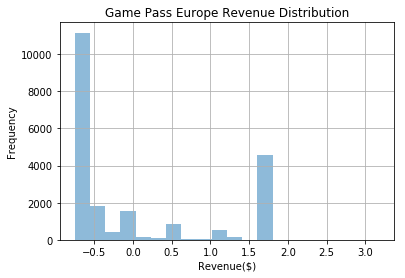

In [44]:
uk_data.standardize_revenue_usd.hist(bins=20, alpha=0.5)
plt.title("Game Pass Europe Revenue Distribution")
plt.xlabel("Revenue($)")
plt.ylabel("Frequency")

In [45]:
uk_data.head()

,transaction_id,segment,gender,age_group,tickets,shop,fantasy,new_to_database,email_opt_in,favourite_team,sku,buy_type,converted_free_trial,revenue_usd,standardize_revenue_usd
0,a-s00338989,Acq,U,26-30,0,0,1,0,1,1,Pro,1,0,179,1.691877
1,a-s00339056,Acq,M,31-35,0,0,1,0,0,1,Pro,0,0,0,-0.749037
2,a-s00339109,Acq,M,22-25,0,0,1,0,0,1,Essential,1,0,52,-0.039945
3,a-s00339192,Ret,U,22-25,0,0,1,0,1,1,Pro,1,0,179,1.691877
6,a-s00339311,Acq,M,51-60,0,1,1,1,1,1,Pro,1,0,181,1.719149


In [46]:
uk_data.columns

Index(['transaction_id', 'segment', 'gender', 'age_group', 'tickets', 'shop',
       'fantasy', 'new_to_database', 'email_opt_in', 'favourite_team', 'sku',
       'buy_type', 'converted_free_trial', 'revenue_usd',
       'standardize_revenue_usd'],
      dtype='object')

#### 1.2 特征值类型的问题

In [47]:
# category编码 - dummy coding
# 这种虚拟变量的做法容易增加数据特征的维度

dummy_data = pd.get_dummies(
        uk_data,columns=['segment', 'gender', 'age_group', 'sku'],
                prefix=['segment', 'gender', 'age_group', 'sku'],prefix_sep="_"
            )

# uk_data = uk_data.drop(['gender_U'], axis=1)

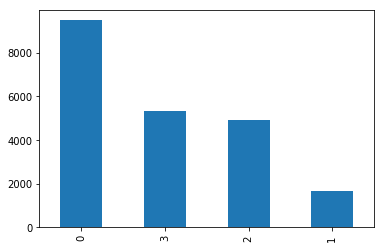

In [48]:
# 连续值转为category

conditions = [
        (uk_data['revenue_usd'] == 0),
        (uk_data['revenue_usd'] <= 13),
        (uk_data['revenue_usd'] <= 98)
        ]
choices = [0,1,2]
dummy_data['revenue_category'] = np.select(conditions, choices, default= 3)
uk_data['revenue_category'] = np.select(conditions, choices, default= 3)

fig, ax = plt.subplots()
dummy_data['revenue_category'].value_counts().plot(ax=ax, kind='bar')



### 2 特征选择

In [49]:
dummy_data.columns

Index(['transaction_id', 'tickets', 'shop', 'fantasy', 'new_to_database',
       'email_opt_in', 'favourite_team', 'buy_type', 'converted_free_trial',
       'revenue_usd', 'standardize_revenue_usd', 'segment_Acq', 'segment_Ret',
       'segment_iOS', 'gender_F', 'gender_M', 'gender_U', 'age_group_18-21',
       'age_group_22-25', 'age_group_26-30', 'age_group_31-35',
       'age_group_36-40', 'age_group_41-50', 'age_group_51-60',
       'age_group_60+', 'age_group_Under 18', 'age_group_Unknown',
       'sku_Essential', 'sku_Free', 'sku_Playoffs', 'sku_Pro',
       'sku_Super Bowl', 'sku_Weekly', 'revenue_category'],
      dtype='object')

In [50]:
# 原则-发散性&关联性

select_feature = ['tickets', 'shop', 'fantasy', 'new_to_database', 'email_opt_in',
                   'favourite_team', 'buy_type', 'converted_free_trial', 'segment_Acq',
                   'segment_Ret', 'segment_iOS', 'gender_F', 'gender_M', 'gender_U',
                   'age_group_18-21', 'age_group_22-25', 'age_group_26-30',
                   'age_group_31-35', 'age_group_36-40', 'age_group_41-50',
                   'age_group_51-60', 'age_group_60+', 'age_group_Under 18',
                   'age_group_Unknown', 'sku_Essential', 'sku_Free', 'sku_Playoffs',
                   'sku_Pro', 'sku_Super Bowl', 'sku_Weekly']

#### 2.1 发散性

In [51]:
# 方差选择法

from sklearn.feature_selection import VarianceThreshold

varianceThreshold = VarianceThreshold(threshold = 0.2)
varianceThreshold.fit_transform(dummy_data[select_feature])
var_result = varianceThreshold.get_support()


#### 2.2 关联性

In [52]:
# 相关系数法
# 选择基本的feature，然后匹配其他
# 注意逻辑关系

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
selectKBest = SelectKBest(f_regression, k=10)
feature = dummy_data[select_feature]
bestFeature = selectKBest.fit_transform(feature, dummy_data[['revenue_usd']])
feature_result = selectKBest.get_support()


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [53]:
def feature_results(list_feature, list_result):
    
    dic = {}
    
    for i in range(len(list_feature)):
        feature = list_feature[i]
        result = list_result[i]
        dic[feature] = result
        result_tuple = sorted(dic.items(), key=lambda kv: kv[1])
    return result_tuple

var_results = feature_results(select_feature, var_result)
weights_results = feature_results(select_feature, feature_result)

print(var_results[-5:-1])
print(weights_results[-10:-1])

[('new_to_database', True), ('favourite_team', True), ('buy_type', True), ('gender_M', True)]
[('tickets', True), ('shop', True), ('fantasy', True), ('favourite_team', True), ('converted_free_trial', True), ('segment_Acq', True), ('segment_Ret', True), ('sku_Free', True), ('sku_Pro', True)]


### 3 维度下降

#### 3.1 逻辑降维

In [54]:
# 根据发散性和关联性的结果，对愿特征进行处理
# 合并tickets、shop、fantasy、new_to_database、email_opt_in，以提高相关性
# 如果可以的话应该加上权重
# uk_data.sku.unique()

uk_data['user_behaviour'] = uk_data['tickets'] + uk_data['shop'] + uk_data['fantasy'] + uk_data['new_to_database'] + uk_data['email_opt_in']    

# age_group 分成老中青 0-21 22-40 40+
uk_data['age'] = np.where((uk_data['age_group']=='Under 18') | (uk_data['age_group']=='18-21'), 'young', 
                          np.where((uk_data['age_group']=='22-25') | (uk_data['age_group']=='26-30') | (uk_data['age_group']=='31-35') | (uk_data['age_group']=='36-40'), 'adult',
                                  'old'))

# sku, buy_ype & converted_free_trial 是属于购买行为了，应该归在target_variable中
uk_data['sku_category'] = np.where((uk_data['sku']=='Pro') & (uk_data['buy_type']== 1), 'Pro-BuyNow', 
                          np.where((uk_data['sku']=='Pro') & (uk_data['buy_type']== 0) & (uk_data['converted_free_trial']== 0), 'Pro-FreeTrial-NoConvert',
                                   np.where((uk_data['sku']=='Pro') & (uk_data['buy_type']== 0) & (uk_data['converted_free_trial']== 1), 'Pro-FreeTrial-Convert',
                                            uk_data['sku'])))
uk_data = uk_data.drop(['tickets', 'shop', 'fantasy', 'new_to_database', 'email_opt_in', 
                          'sku', 'buy_type', 'converted_free_trial', 'age_group', 'standardize_revenue_usd'], axis=1)

uk_data = uk_data[['transaction_id', 'age','gender', 'favourite_team', 'user_behaviour', 'segment', 'revenue_usd', 'sku_category', 'revenue_category']]
uk_data.head(10)

,transaction_id,age,gender,favourite_team,user_behaviour,segment,revenue_usd,sku_category,revenue_category
0,a-s00338989,adult,U,1,2,Acq,179,Pro-BuyNow,3
1,a-s00339056,adult,M,1,1,Acq,0,Pro-FreeTrial-NoConvert,0
2,a-s00339109,adult,M,1,1,Acq,52,Essential,2
3,a-s00339192,adult,U,1,2,Ret,179,Pro-BuyNow,3
6,a-s00339311,old,M,1,4,Acq,181,Pro-BuyNow,3
9,a-s00339504,adult,M,1,1,Acq,0,Pro-FreeTrial-NoConvert,0
15,a-s00339778,adult,M,1,3,Ret,179,Pro-BuyNow,3
16,a-s00338991,old,U,0,1,Acq,179,Pro-BuyNow,3
17,a-s00339062,adult,U,1,2,Acq,178,Pro-FreeTrial-Convert,3
18,a-s00339114,adult,M,1,2,Acq,179,Pro-BuyNow,3


In [55]:
# 哑编码，以适应某些模型不接受categorical data
dummy_data = pd.get_dummies(
        uk_data,columns=['age', 'gender', 'segment'],
                prefix=['age', 'gender', 'segment'],prefix_sep="_"
            )


In [56]:
dummy_data.head()

,transaction_id,favourite_team,user_behaviour,revenue_usd,sku_category,revenue_category,age_adult,age_old,age_young,gender_F,gender_M,gender_U,segment_Acq,segment_Ret,segment_iOS
0,a-s00338989,1,2,179,Pro-BuyNow,3,1,0,0,0,0,1,1,0,0
1,a-s00339056,1,1,0,Pro-FreeTrial-NoConvert,0,1,0,0,0,1,0,1,0,0
2,a-s00339109,1,1,52,Essential,2,1,0,0,0,1,0,1,0,0
3,a-s00339192,1,2,179,Pro-BuyNow,3,1,0,0,0,0,1,0,1,0
6,a-s00339311,1,4,181,Pro-BuyNow,3,0,1,0,0,1,0,1,0,0


In [57]:
# 将哑编码与原数据结合
feature_data = pd.merge(dummy_data, uk_data[['transaction_id', 'age', 'gender', 'segment']], on='transaction_id', how='inner')
feature_data.head()


,transaction_id,favourite_team,user_behaviour,revenue_usd,sku_category,revenue_category,age_adult,age_old,age_young,gender_F,gender_M,gender_U,segment_Acq,segment_Ret,segment_iOS,age,gender,segment
0,a-s00338989,1,2,179,Pro-BuyNow,3,1,0,0,0,0,1,1,0,0,adult,U,Acq
1,a-s00339056,1,1,0,Pro-FreeTrial-NoConvert,0,1,0,0,0,1,0,1,0,0,adult,M,Acq
2,a-s00339109,1,1,52,Essential,2,1,0,0,0,1,0,1,0,0,adult,M,Acq
3,a-s00339192,1,2,179,Pro-BuyNow,3,1,0,0,0,0,1,0,1,0,adult,U,Ret
4,a-s00339311,1,4,181,Pro-BuyNow,3,0,1,0,0,1,0,1,0,0,old,M,Acq


In [58]:
# 透视表

"""
feature_data['transaction_count'] = 1
pd.pivot_table(feature_data,
               columns=["age"],
               index = ['favourite_team'],
               values=['revenue_usd', 'transaction_count'],
               aggfunc=[np.mean,np.sum])
"""

'\nfeature_data[\'transaction_count\'] = 1\npd.pivot_table(feature_data,\n               columns=["age"],\n               index = [\'favourite_team\'],\n               values=[\'revenue_usd\', \'transaction_count\'],\n               aggfunc=[np.mean,np.sum])\n'

In [59]:
# 相关性可视化

"""
variables = ['favourite_team', 'user_behaviour', 'revenue_usd', 'age_adult', 'age_old', 'age_young',
       'gender_F', 'gender_M', 'segment_Acq', 'segment_Ret', 'segment_iOS']

sns.set()
sns.pairplot(feature_data[variables], size = 2.5)
plt.show()
"""

"\nvariables = ['favourite_team', 'user_behaviour', 'revenue_usd', 'age_adult', 'age_old', 'age_young',\n       'gender_F', 'gender_M', 'segment_Acq', 'segment_Ret', 'segment_iOS']\n\nsns.set()\nsns.pairplot(feature_data[variables], size = 2.5)\nplt.show()\n"

In [60]:
# 多重共线性检验

"""

x = feature_data[['favourite_team', 'user_behaviour', 'age_adult', 'age_old', 'age_young',
       'gender_F', 'gender_M', 'segment_Acq', 'segment_Ret', 'segment_iOS']]

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns

vif.round(1)
"""

'\n\nx = feature_data[[\'favourite_team\', \'user_behaviour\', \'age_adult\', \'age_old\', \'age_young\',\n       \'gender_F\', \'gender_M\', \'segment_Acq\', \'segment_Ret\', \'segment_iOS\']]\n\nfrom statsmodels.stats.outliers_influence import variance_inflation_factor\n\nvif = pd.DataFrame()\nvif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]\nvif["features"] = x.columns\n\nvif.round(1)\n'

In [61]:
feature_data.to_csv(r'/Users/apple/Downloads/nfl/feature_data.csv', index=True)

#### 3.2 算法试验

In [62]:
feature_data.columns

Index(['transaction_id', 'favourite_team', 'user_behaviour', 'revenue_usd',
       'sku_category', 'revenue_category', 'age_adult', 'age_old', 'age_young',
       'gender_F', 'gender_M', 'gender_U', 'segment_Acq', 'segment_Ret',
       'segment_iOS', 'age', 'gender', 'segment'],
      dtype='object')

In [63]:
# 检验方法-train-validation
from sklearn.model_selection import train_test_split

x = feature_data[['favourite_team', 'user_behaviour', 'age_adult', 'age_old', 'age_young',
                   'gender_F', 'gender_M', 'segment_Acq', 'segment_Ret', 'segment_iOS']]
y1 = feature_data[['revenue_usd']] #regression
y2 = feature_data[['revenue_category']] #classification


x_train1, x_val1, y_train1, y_val1 = train_test_split(x, y1, test_size=0.2, random_state=1)
x_train2, x_val2, y_train2, y_val2 = train_test_split(x, y2, test_size=0.2, random_state=1)

print("the number of data for training:")
print(y_train1.count())
print("the number of data for validation:")
print(y_val1.count())


the number of data for training:
revenue_usd    17139
dtype: int64
the number of data for validation:
revenue_usd    4285
dtype: int64


In [74]:
#衡量方法-accuracy与RMSE

from sklearn.metrics import mean_squared_error

def rmse_model(model, x, y):
    predictions = model.predict(x)
    rmse = np.sqrt(mean_squared_error(predictions, y))
    return rmse


"""
from sklearn import metrics

def confusion_matrix(model, x, y):
    model_confusion_test = metrics.confusion_matrix(y, model.predict(x))
    matrix = pd.DataFrame(data = model_confusion_test, columns = ['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'],
                 index = ['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'])
    return matrix
"""

"\nfrom sklearn import metrics\n\ndef confusion_matrix(model, x, y):\n    model_confusion_test = metrics.confusion_matrix(y, model.predict(x))\n    matrix = pd.DataFrame(data = model_confusion_test, columns = ['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'],\n                 index = ['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'])\n    return matrix\n"

In [65]:
# regression
# 由于运算量和时间问题，就只放上代码了

"""
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()
linear_regression.fit(x_train1, y_train1)

print(rmse_model(linear_regression, x_val1, y_val1))
"""

'\nfrom sklearn.linear_model import LinearRegression\n\nlinear_regression = LinearRegression()\nlinear_regression.fit(x_train1, y_train1)\n\nprint(rmse_model(linear_regression, x_val1, y_val1))\n'

In [66]:
# bias-variance trade-off

"""
from sklearn.preprocessing import PolynomialFeatures

train_rmses = []
val_rmses = []
degrees = range(1,8)

for i in degrees:
    
    poly = PolynomialFeatures(degree=i, include_bias=False)
    x_train_poly = poly.fit_transform(x_train1)

    poly_reg = LinearRegression()
    poly_reg.fit(x_train_poly, y_train1)
    
    # training RMSE
    y_train_pred = poly_reg.predict(x_train_poly)
    train_poly_rmse = np.sqrt(mean_squared_error(y_train1, y_train_pred))
    
    train_rmses.append(train_poly_rmse)
    
    # validation RMSE
    x_val_poly = poly.fit_transform(x_val1)
    y_val_pred = poly_reg.predict(x_val_poly)
    
    val_poly_rmse = np.sqrt(mean_squared_error(y_val1, y_val_pred))
    val_rmses.append(val_poly_rmse)

    print('degree = %s, training RMSE = %.2f, validation RMSE = %.2f' % (i, train_poly_rmse, val_poly_rmse))
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(degrees, train_rmses,label= 'training set')
ax.plot(degrees, val_rmses,label= 'validation set')
ax.set_yscale('log')
ax.set_xlabel('Degree')
ax.set_ylabel('RMSE')
ax.set_title('Bias/Variance Trade-off')  
plt.legend()
plt.show()
"""


"\nfrom sklearn.preprocessing import PolynomialFeatures\n\ntrain_rmses = []\nval_rmses = []\ndegrees = range(1,8)\n\nfor i in degrees:\n    \n    poly = PolynomialFeatures(degree=i, include_bias=False)\n    x_train_poly = poly.fit_transform(x_train1)\n\n    poly_reg = LinearRegression()\n    poly_reg.fit(x_train_poly, y_train1)\n    \n    # training RMSE\n    y_train_pred = poly_reg.predict(x_train_poly)\n    train_poly_rmse = np.sqrt(mean_squared_error(y_train1, y_train_pred))\n    \n    train_rmses.append(train_poly_rmse)\n    \n    # validation RMSE\n    x_val_poly = poly.fit_transform(x_val1)\n    y_val_pred = poly_reg.predict(x_val_poly)\n    \n    val_poly_rmse = np.sqrt(mean_squared_error(y_val1, y_val_pred))\n    val_rmses.append(val_poly_rmse)\n\n    print('degree = %s, training RMSE = %.2f, validation RMSE = %.2f' % (i, train_poly_rmse, val_poly_rmse))\n        \nfig = plt.figure()\nax = fig.add_subplot(111)\nax.plot(degrees, train_rmses,label= 'training set')\nax.plot(degree

In [67]:
# regularization in order to reduce the effect of overfitting
# ridge (lasso, elasticnet代码相似，lasso和elasticnet对RMSE压缩得更狠一些，不过不会去掉有collinearity的feature，ridge相反)

"""
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

rmse=[]
alpha=[1, 2, 5, 10, 20, 30, 40, 50, 75, 100]

for a in alpha:
    ridge = make_pipeline(PolynomialFeatures(4), Ridge(alpha=a))
    ridge.fit(x_train1, y_train1)
    predict=ridge.predict(x_val1)
    rmse.append(np.sqrt(mean_squared_error(predict, y_val1)))
print(rmse)
plt.scatter(alpha, rmse)

alpha=np.arange(20, 60, 2)
rmse=[]
for a in alpha:
    #ridge=Ridge(alpha=a, copy_X=True, fit_intercept=True)
    #ridge.fit(x_train1, y_train1)
    ridge = make_pipeline(PolynomialFeatures(4), Ridge(alpha=a))
    ridge.fit(x_train1, y_train1)
    predict=ridge.predict(x_val1)
    rmse.append(np.sqrt(mean_squared_error(predict, y_val1)))
print(rmse)
plt.scatter(alpha, rmse)

ridge = make_pipeline(PolynomialFeatures(4), Ridge(alpha=24.6))
ridge_model = ridge.fit(x_train1, y_train1)
predictions = ridge_model.predict(x_val1)
print("Ridge RMSE is: " + str(rmse_model(ridge_model, x_val1, y_val1)))
"""

'\nfrom sklearn.linear_model import Ridge\nfrom sklearn.pipeline import make_pipeline\n\nrmse=[]\nalpha=[1, 2, 5, 10, 20, 30, 40, 50, 75, 100]\n\nfor a in alpha:\n    ridge = make_pipeline(PolynomialFeatures(4), Ridge(alpha=a))\n    ridge.fit(x_train1, y_train1)\n    predict=ridge.predict(x_val1)\n    rmse.append(np.sqrt(mean_squared_error(predict, y_val1)))\nprint(rmse)\nplt.scatter(alpha, rmse)\n\nalpha=np.arange(20, 60, 2)\nrmse=[]\nfor a in alpha:\n    #ridge=Ridge(alpha=a, copy_X=True, fit_intercept=True)\n    #ridge.fit(x_train1, y_train1)\n    ridge = make_pipeline(PolynomialFeatures(4), Ridge(alpha=a))\n    ridge.fit(x_train1, y_train1)\n    predict=ridge.predict(x_val1)\n    rmse.append(np.sqrt(mean_squared_error(predict, y_val1)))\nprint(rmse)\nplt.scatter(alpha, rmse)\n\nridge = make_pipeline(PolynomialFeatures(4), Ridge(alpha=24.6))\nridge_model = ridge.fit(x_train1, y_train1)\npredictions = ridge_model.predict(x_val1)\nprint("Ridge RMSE is: " + str(rmse_model(ridge_model, 

In [68]:
# classfication
list(y_train2['revenue_category'].unique())

[0, 2, 3, 1]

0.48124161269619
0.4793465577596266


Text(0, 0.5, 'Accuracy')

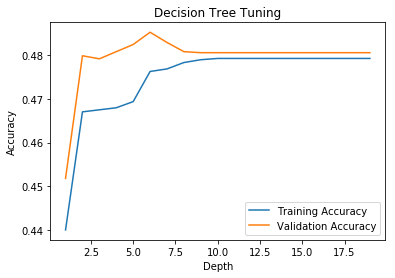

In [69]:
# decision tree

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

decision_tree_model = DecisionTreeClassifier(criterion='entropy')
decision_tree_model.fit(x_train2, y_train2)
print(decision_tree_model.score(x_train2,y_train2))
print(decision_tree_model.score(x_val2,y_val2))

# tuning
train_score = []
val_score = []
for depth in np.arange(1,20):
    decision_tree = tree.DecisionTreeClassifier(max_depth = depth,min_samples_leaf = 5)
    decision_tree.fit(x_train2, y_train2)
    train_score.append(decision_tree.score(x_train2, y_train2))
    val_score.append(decision_tree.score(x_val2, y_val2))

plt.plot(np.arange(1,20),train_score)
plt.plot(np.arange(1,20),val_score)
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.title('Decision Tree Tuning')
plt.xlabel('Depth')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

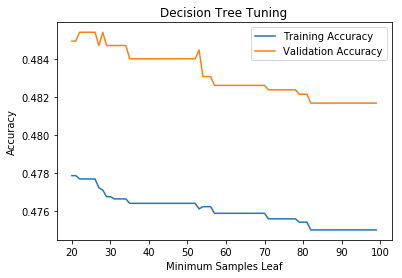

In [70]:
train_score = []
val_score = []
for leaf in np.arange(20,100):
    decision_tree = tree.DecisionTreeClassifier(max_depth = 10, min_samples_leaf = leaf)
    decision_tree.fit(x_train2, y_train2)
    train_score.append(decision_tree.score(x_train2, y_train2))
    val_score.append(decision_tree.score(x_val2, y_val2))

plt.plot(np.arange(20,100),train_score)
plt.plot(np.arange(20,100),val_score)
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.title('Decision Tree Tuning')
plt.xlabel('Minimum Samples Leaf')
plt.ylabel('Accuracy')

In [71]:
my_decision_tree_model = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 20)
my_decision_tree_model.fit(x_train2, y_train2)
print(my_decision_tree_model.score(x_train2,y_train2))
print(my_decision_tree_model.score(x_val2,y_val2))

0.47785751794153686
0.4849474912485414


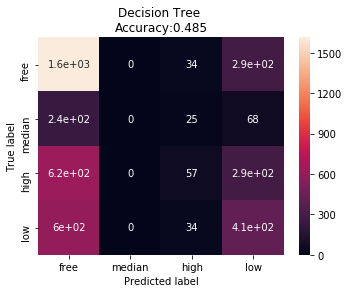

In [75]:
# confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support


y_predict = my_decision_tree_model.predict(x_val2)
cm = confusion_matrix(y_val2, y_predict) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['free', 'median', 'high', 'low'], 
                     columns = ['free', 'median', 'high', 'low'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Decision Tree \nAccuracy:{0:.3f}'.format(accuracy_score(y_val2, y_predict)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

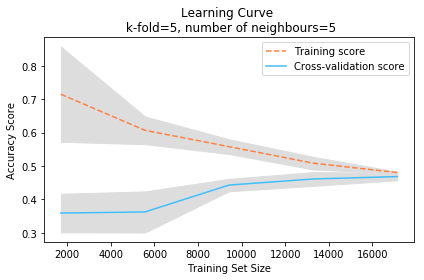

In [76]:
# learning curve

from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 20), 
        x, 
        y2,
        # Number of folds in cross-validation
        cv=5,
        # Evaluation metric
        scoring='accuracy',
        # Use all computer cores
        n_jobs=-1, 
        # 50 different sizes of the training set
        train_sizes=np.linspace(0.1, 1.0, 5))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of validation set scores
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#ff8040",  label="Training score")
plt.plot(train_sizes, val_mean, color="#40bfff", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve \n k-fold=5, number of neighbours=5")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [78]:
# Curse of Dimensionality

d_train = []
d_val = []

for i in range(1,9):
    
    X_train_index = x_train2.iloc[: , 0:i]
    X_val_index = x_val2.iloc[: , 0:i]
    
    classifier = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 20)
    dt_model = classifier.fit(X_train_index, y_train2.values.ravel())

    d_train.append(dt_model.score(X_train_index, y_train2))
    d_val.append(dt_model.score(X_val_index, y_val2))

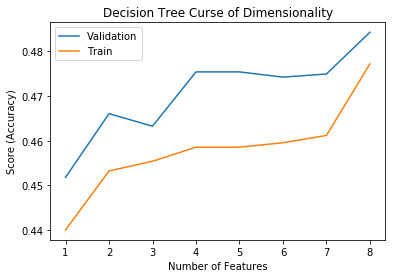

In [79]:
plt.title('Decision Tree Curse of Dimensionality')
plt.plot(range(1,9),d_val,label="Validation")
plt.plot(range(1,9),d_train,label="Train")
plt.xlabel('Number of Features')
plt.ylabel('Score (Accuracy)')
plt.legend()
plt.xticks(range(1,9))
plt.show()